In [1]:
from pathlib import Path

import jupyter_black
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from hydra import compose
from hydra import initialize
from hydra.core.global_hydra import GlobalHydra

from src.utils.metrics import event_detection_ap
from src.utils.post_process import post_process_for_seg

jupyter_black.load()
# plt.style.use("ggplot")
sns.set()

%load_ext autoreload
%autoreload 2


def load_config(result_dir: Path):
    # clear previous initialization
    GlobalHydra.instance().clear()

    # initialize hydra
    config_path = result_dir / ".hydra"
    initialize(config_path=config_path.as_posix())
    # load the config
    cfg = compose(config_name="config")

    return cfg

In [2]:
EXP_NAME = "exp125"
RUN_NAMES = ["run0", "run1", "run2", "run3", "run4"]
all_preds = []
all_keys = []
all_labels = []
for run_name in RUN_NAMES:
    RESULT_DIR = Path("../output/train") / EXP_NAME / run_name
    cfg = load_config(RESULT_DIR)
    preds = np.load(RESULT_DIR / "preds.npy")
    labels = np.load(RESULT_DIR / "labels.npy")
    keys = np.load(RESULT_DIR / "keys.npy")
    all_preds.append(preds)
    all_keys.append(keys)
    all_labels.append(labels)

all_preds = np.concatenate(all_preds)
all_keys = np.concatenate(all_keys)
all_labels = np.concatenate(all_labels)
gt_df = pd.read_csv(Path(cfg.dir.data_dir) / "train_events.csv").dropna().reset_index(drop=True)

/tmp/ipykernel_2093317/122198152.py:32: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())
/tmp/ipykernel_2093317/122198152.py:32: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())


In [3]:
train = pl.read_parquet(Path(cfg.dir.data_dir) / "train_series.parquet")

In [4]:
cfg.post_process.score_th = 0.001
cfg.post_process.distance = 70
cfg.post_process.low_pass_filter_hour = 5

In [5]:
pred_df1: pl.DataFrame = post_process_for_seg(
    all_keys,
    all_preds[:, :, [1, 2]],
    train,
    score_th=cfg.post_process.score_th,
    distance=cfg.post_process.distance,
    low_pass_filter_hour=cfg.post_process.low_pass_filter_hour,
    use_hour_prob=False,
)
score1 = event_detection_ap(
    gt_df.query(f'series_id in {pred_df1["series_id"].unique().to_list()}'), pred_df1.to_pandas()
)
score1

100%|██████████| 277/277 [00:08<00:00, 32.66it/s]


0.7862887979283817

In [6]:
pred_df2: pl.DataFrame = post_process_for_seg(
    all_keys,
    all_preds[:, :, [1, 2]],
    train,
    score_th=cfg.post_process.score_th,
    distance=cfg.post_process.distance,
    low_pass_filter_hour=cfg.post_process.low_pass_filter_hour,
    use_hour_prob=True,
)
score2 = event_detection_ap(
    gt_df.query(f'series_id in {pred_df2["series_id"].unique().to_list()}'), pred_df2.to_pandas()
)
score2

  0%|          | 0/277 [00:00<?, ?it/s]/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:81: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  (pl.col(event_name) * pl.col("hour").apply(lambda x: prob_dict[x]))
/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:81: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  (pl.col(event_name) * pl.col("hour").apply(lambda x: prob_dict[x]))
  0%|          | 1/277 [00:00<01:57, 

0.7832528471986494

In [7]:
for sigma in [1, 3, 5, 7, 9]:
    pred_df2: pl.DataFrame = post_process_for_seg(
        all_keys,
        all_preds[:, :, [1, 2]],
        train,
        score_th=cfg.post_process.score_th,
        distance=cfg.post_process.distance,
        low_pass_filter_hour=cfg.post_process.low_pass_filter_hour,
        use_hour_prob=True,
        sigma=sigma,
    )
    score2 = event_detection_ap(
        gt_df.query(f'series_id in {pred_df2["series_id"].unique().to_list()}'),
        pred_df2.to_pandas(),
    )
    print(f"sigma={sigma} score={score2:.5f}")

  0%|          | 0/277 [00:00<?, ?it/s]/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  .alias('prob')
/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  .alias('prob')
  0%|          | 1/277 [00:00<01:57,  2.35it/s]/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Ex

sigma=1 score=0.69450


  0%|          | 0/277 [00:00<?, ?it/s]/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  .alias('prob')
/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  .alias('prob')
  0%|          | 1/277 [00:00<02:04,  2.21it/s]/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Ex

sigma=3 score=0.77459


  0%|          | 0/277 [00:00<?, ?it/s]/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  .alias('prob')
/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  .alias('prob')
  0%|          | 1/277 [00:00<01:59,  2.30it/s]/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Ex

sigma=5 score=0.78325


  0%|          | 0/277 [00:00<?, ?it/s]/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  .alias('prob')
/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  .alias('prob')
  0%|          | 1/277 [00:00<02:04,  2.22it/s]/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Ex

sigma=7 score=0.78520


  0%|          | 0/277 [00:00<?, ?it/s]/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  .alias('prob')
/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  .alias('prob')
  0%|          | 1/277 [00:00<02:00,  2.29it/s]/home/kuto/kaggle/kaggle-sleep-v2/src/utils/post_process.py:82: PolarsInefficientMapWarning: 
Ex

sigma=9 score=0.78584


- seriesに対して平均onsetとwakeupを計算
- そこを基準として分散を設定して事前分布を設定
- 事前分布に予測値をかけてそれを事後分布とする

In [37]:
def get_prob_dict(mu, sigma=10):
    direct_distance = np.abs(np.arange(0, 24) - mu)
    circular_distance = np.minimum(direct_distance, 24 - direct_distance)
    prob = norm.pdf(circular_distance, 0, sigma)
    prob_dict = {}
    for i in range(24):
        prob_dict[i] = prob[i]

    # min-max scaling
    prob_dict = {k: v / max(prob_dict.values()) for k, v in prob_dict.items()}
    return prob_dict

In [52]:
from scipy.stats import norm

peak_thr = 0.1
sigma = 0.1
mu = 20
prob_dict = get_prob_dict(mu, sigma)
prob_dict

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 3.693883068487256e-196,
 18: 1.3838965267367376e-87,
 19: 1.9287498479639178e-22,
 20: 1.0,
 21: 1.9287498479639178e-22,
 22: 1.3838965267367376e-87,
 23: 3.693883068487256e-196}

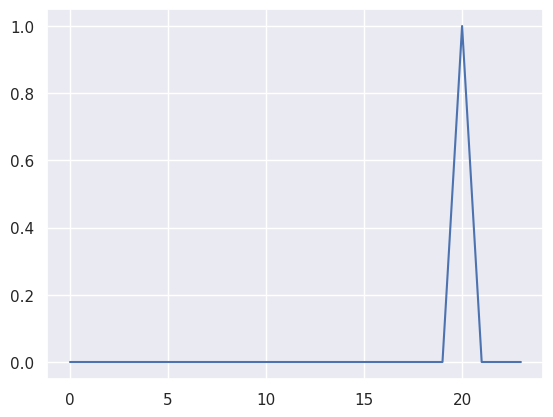

In [53]:
plt.plot(prob_dict.values())

In [54]:
df = train.with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z").dt.hour().alias("hour")
)

In [55]:
series_ids = np.array(list(map(lambda x: x.split("_")[0], all_keys)))
unique_series_ids = np.unique(series_ids)
records = []
for series_id in unique_series_ids:
    break

series_idx = np.where(series_ids == series_id)[0]
this_series_preds = all_preds[series_idx].reshape(-1, 2)
series_df = df.filter(pl.col("series_id") == series_id)
series_df = series_df.with_columns(
    pl.lit(this_series_preds[: len(series_df), 0]).alias("onset"),
    pl.lit(this_series_preds[: len(series_df), 1]).alias("wakeup"),
)

In [56]:
for i, event_name in enumerate(["onset", "wakeup"]):
    this_event_preds = this_series_preds[:, i]
    peak_thr = 0.1
    sigma = 0.1
    mu = series_df.filter(pl.col(event_name) > peak_thr)["hour"].mean()
    prob_dict = get_prob_dict(mu, sigma)
    series_df = series_df.with_columns(
        (pl.col("hour").apply(lambda x: prob_dict[x])).alias("prob")
    )
    # this_event_preds = (
    #     series_df.with_columns(
    #         (pl.col(event_name) * pl.col("hour").apply(lambda x: prob_dict[x])).alias("prob")
    #     )
    #     .select("prob")
    #     .to_numpy()
    #     .flatten()
    # )
    break

/tmp/ipykernel_2076529/1231159369.py:8: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  (pl.col("hour").apply(lambda x: prob_dict[x])).alias("prob")
/tmp/ipykernel_2076529/1231159369.py:8: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("hour").map_elements(lambda x: ...)
  + pl.col("hour").map_dict(prob_dict)

  (pl.col("hour").apply(lambda x: prob_dict[x])).alias("prob")


/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

<Axes: xlabel='step', ylabel='onset'>

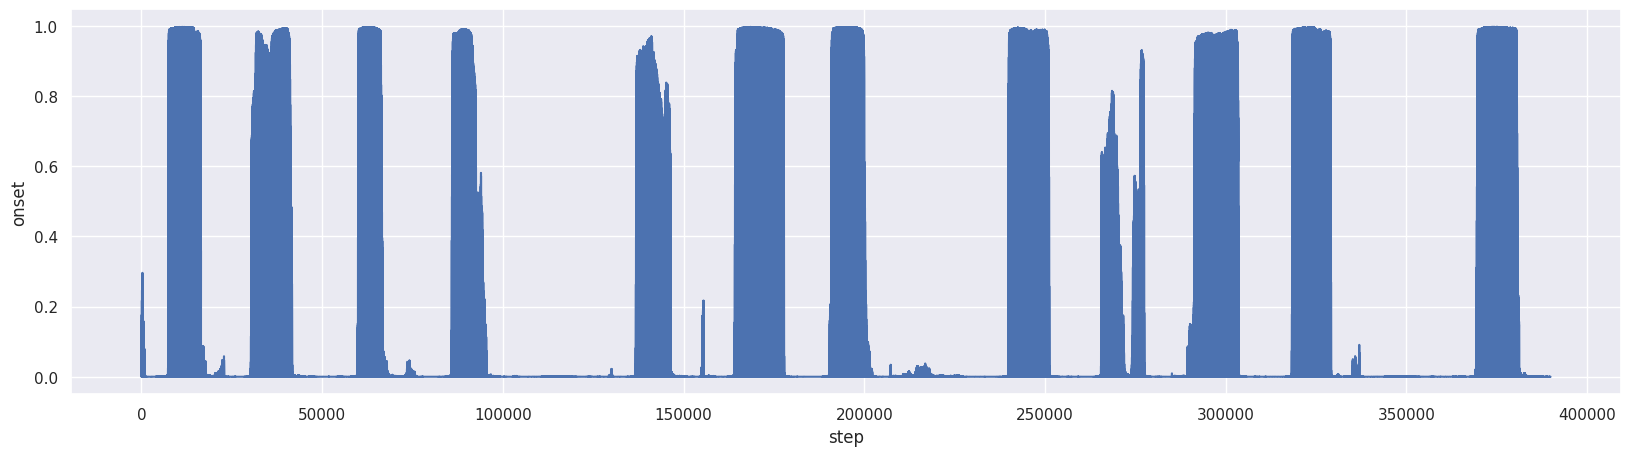

In [68]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=series_df.to_pandas(), x="step", y="onset")